In [1]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#from wordcloud import WordCloud
import pandas as pd
import numpy as np
from datetime import datetime
import os
import string
from nltk.probability import FreqDist

In [2]:
def read_txt_data(filename):
    with open(filename) as f:
        return [line.rstrip().split(",") for line in f]
    
def read_txt_label(filename):
    with open(filename) as f:
        return [line.rstrip() for line in f]

In [3]:
covid_data = read_txt_data('./covid.data.txt')
covid_label = read_txt_label('./covid_label.txt')


In [4]:
def preprocess_data(data):
    
    # date: year, month, day
    data['datetime_obj'] = datetime.strptime(data['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    return {
        'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        'month': int(data['datetime_obj'].month),
        'text': data['text'], 
        #'lang': data['lang'],
        'retweet_count': data['public_metrics']['retweet_count'],
        #'verified': int(data['user']['verified']),
        #'followers_count': data['user']['followers_count'],
        'favorite_count': data['public_metrics']['like_count'],
        'reply_count': data['public_metrics']['reply_count']
        #'location': data['user']['location']
    }

def preprocess_user(data):
    return {
        #'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        #'month': int(data['datetime_obj'].month),
        #'text': data['text'], 
        #'lang': data['lang'],
        #'retweet_count': data['user']['retweet_count'],
        'verified': int(data['user']['verified']),
        'followers_count': data['user']['followers_count'],
        #'favorite_count': data['public_metrics']['like_count'],
        'location': data['user']['location']
    }

In [5]:
# 先做15956 的covid tweet 这个是feed给分类器的 
# include text, created_at, like_count, retweet_count
# 还需要include location, follower count
# check duplicate tweet, combine 墨学 和自己的covid tweet
filename_tweets= './covid_object/{}.json' # covid_object contains user info

rumor_list = list() # store rumor tweets ids
nonrumor_list = list() # store non-rumor tweets ids
r_reply = list() # store the id of rumor replies
nonr_reply = list() # store the id of nonrumor replies
counter = 0
for data in covid_data:
    if not os.path.exists(filename_tweets.format(data[0])):
        continue
    if covid_label[counter] == '1':
        rumor_list.append(data[0])
        for d in data[1:]:
            r_reply.append(d)
    else:
        nonrumor_list.append(data[0])
        for d in data[1:]:
            nonr_reply.append(d)
    counter += 1

#rumor_df = pd.DataFrame(rumor_list)
#nonrumor_df = pd.DataFrame(nonrumor_list)

In [6]:
# store rumor and non_rumor text, date, and some public_metrics
# store rumor and non_rumor users info as well

filename = './analysis_tweet/{}.json' # analysis_tweet contains full text tweets
rumor = list()
nonrumor = list()

for data in rumor_list:
    if not os.path.exists(filename.format(data)):
        continue
    x = preprocess_data(json.load(open(filename.format(data))))
    y = preprocess_user(json.load(open(filename_tweets.format(data))))
    x.update(y)
    rumor.append(x)
    
for data in nonrumor_list:
    if not os.path.exists(filename.format(data)):
        continue
    x = preprocess_data(json.load(open(filename.format(data))))
    y = preprocess_user(json.load(open(filename_tweets.format(data))))
    x.update(y)
    nonrumor.append(x)

# Store a dataframe of rumor and nonrumor
rumor_df = pd.DataFrame(rumor)
nonrumor_df = pd.DataFrame(nonrumor)

In [7]:
rumor_df.head()

,id,month,text,retweet_count,favorite_count,reply_count,verified,followers_count,location
0,1266555444283179008,5,Monkeys on the loose in India with stolen coro...,72,166,52,1,4346041,"Washington, DC"
1,1274338812173393920,6,"“If Trump felt comfortable having it here, the...",786,1976,1159,1,205614,"Washington, DC"
2,1274091468890632192,6,KHive has become the most toxic thing on Twitt...,103,511,132,0,59058,Los Angeles
3,1265729173961748480,5,A doctor treating coronavirus victims and her ...,88,160,24,1,44994,Ohio
4,1275965523625418753,6,Trump has royally fucked up this country.,32060,241873,7810,1,6671118,


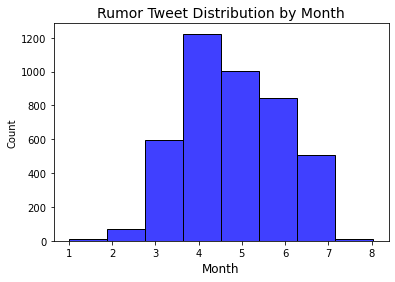

In [8]:
#s = [11, 72, 597, 1224, 1002, 843, 510, 8]

sns.histplot(data=rumor_df, x="month", color="blue", binwidth=0.88)
plt.title('Rumor Tweet Distribution by Month', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.show()

## Topic Overtime

In [9]:
# sort rumor tweets
rumor_df.sort_values(['month'],inplace=True)
# sort nonrumor tweets
nonrumor_df.sort_values(['month'],inplace=True)

In [41]:
# 分成每2个months 5个topic好了 
rumor_jan = rumor_df.loc[rumor_df.month==1]
rumor_feb = rumor_df.loc[rumor_df.month==2]
rumor_mar = rumor_df.loc[rumor_df.month==3]
rumor_apr = rumor_df.loc[rumor_df.month==4]
rumor_may = rumor_df.loc[rumor_df.month==5]
rumor_jun = rumor_df.loc[rumor_df.month==6]
rumor_jul = rumor_df.loc[rumor_df.month==7]
rumor_aug = rumor_df.loc[rumor_df.month==8]

rumor_part1 = rumor_jan.append(rumor_feb).append(rumor_mar)
rumor_part2 = rumor_apr.append(rumor_may)
rumor_part3 = rumor_jun.append(rumor_jul).append(rumor_aug)

In [42]:
def preprocess(text):
    new_text = []
    text = text.replace('\n', ' ') # replace newline with whitespace
    for t in text.split(" "):
        if not t.startswith('@') and not t.startswith('http'):
            if t.startswith('#'):
                t = t[1:]
            new_text.append(t)
    return " ".join(new_text)

rumor_text = [preprocess(x) for x in rumor_df['text']] # stores rumor text without https, @, and hashtags
rumor_text1 = [preprocess(x) for x in rumor_part1['text']] # topics over january, feburary, and march
rumor_text2 = [preprocess(x) for x in rumor_part2['text']] # topics in april and may
rumor_text3 = [preprocess(x) for x in rumor_part3['text']] # topics in june, july and august
nonrumor_text = [preprocess(x) for x in nonrumor_df['text']] # stores nonrumor text without https, @, and hashtags

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

tt = TweetTokenizer()

# lemmatize
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word, "v")
    if lemma == word:
        lemma = lemmatizer.lemmatize(word, "n")
    return lemma

stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase

## Topic Extraction

In [76]:
# Topic extraction using LDA

# preprocess text: remove urls, tokenize each tweet, remove stopwords, punctuation, and lowercase words
# remove any remaining special characters, lemmatize text

# add coronavirus and covid to stopwords
stopwords.add('coronavirus')
stopwords.add('covid')

rumor_lda = list()
nonrumor_lda = list()

for t in rumor_text3: # change here to change rumor tweets time range
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        if any(c.encode("UTF-8").isalpha() for c in w): # step3 remove if does not contain alphabet
            w = lemmatize(w) # lemmatize
            if w not in stopwords and len(w) > 3: # step4 remove stopwords and words less than length 2
                if not w.startswith('http') and not w.startswith('#'):
                    text.append(w)
    if(len(text) > 4): # remove tweets that are too short
        rumor_lda.append(text)


for t in nonrumor_text:
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        if any(c.encode("UTF-8").isalpha() for c in w): # step3 remove if does not contain alphabet
            w = lemmatize(w) # lemmatize
            if w not in stopwords and len(w) > 3: # step4 remove stopwords and words less than length 2
                text.append(w)
    if(len(text) > 7): # remove tweets that are too short
        nonrumor_lda.append(text)


In [77]:
# LDA have inbuilt TF-IDF vectorizer, we can just use a BOW representation
# rumor_lda contains processed tweet text from rumor set
# nonrumor_lda contains contains processed tweet text from nonrumor set
# we can also exclude words like covid coronavirus, or tweet length < 4
# or words that are too short. 

from gensim.corpora import Dictionary

# create dictionary
rumor_dict = Dictionary(rumor_lda)
nonrumor_dict = Dictionary(nonrumor_lda)

# view integer mapping
# rumor_dict.token2id 

rumor_bow = [rumor_dict.doc2bow(tweet) for tweet in rumor_lda]
nonrumor_bow = [nonrumor_dict.doc2bow(tweet) for tweet in nonrumor_lda]

In [78]:
# fitting into LDA model

from gensim.models.ldamodel import LdaModel 

rumor_lda_model = LdaModel(rumor_bow, num_topics = 12, id2word = rumor_dict, random_state = 17) #,alpha=[0.01]*15,eta=[0.01]*len(rumor_dict.keys()))

#nonrumor_lda_model = LdaModel(nonrumor_bow, num_topics = 15, id2word = nonrumor_dict, random_state = 17)
#rumor_lda_model.show_topics()

In [79]:
# Show LDA Topics
def get_lda_topics(model, num_topics, top_n_words):
     word_dict = {}
     for i in range(num_topics):
         word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in model.show_topic(i, topn = top_n_words)];
 
     return pd.DataFrame(word_dict)
print('Rumor Topics of LDA model')
get_lda_topics(rumor_lda_model,12,15)

Rumor Topics of LDA model


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,case,case,death,case,trump,trump,trump,trump,trump,trump,case,trump
1,florida,texas,case,state,case,case,know,case,state,death,trump,test
2,report,people,trump,fauci,florida,president,president,florida,president,president,report,rally
3,people,state,president,trump,fauci,test,mask,think,people,million,president,american
4,trump,kill,pandemic,like,texas,state,death,people,america,florida,death,positive
5,state,trump,rally,death,number,people,american,state,like,american,test,time
6,pandemic,pandemic,report,surge,american,florida,wear,report,florida,test,american,people
7,virus,number,public,spread,live,week,today,mask,rally,case,record,house
8,even,test,million,month,state,american,number,show,racist,report,biden,president
9,desantis,report,people,break,make,june,people,even,hoax,state,people,pandemic


## Non-rumor topics 
print("Non-Rumor Topics of LDA model")
get_lda_topics(nonrumor_lda_model, 10, 15)